In [1]:
import pints
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
class ODEModel(pints.ForwardModel, pints.ToyModel):
    def __init__(self, initial_condition=0.3):
        super(ODEModel, self).__init__()

        # Initial conditions
        self._n0 = float(initial_condition)
        if self._n0 <= 0 or self._n0 >= 1:
            raise ValueError('Initial condition must be > 0 and < 1.')

        # Reversal potential, in mV
        self._E_k = -88

        # Maximum conductance, in mS/cm^2
        self._g_max = 36

        # Voltage step protocol
        self._t_hold = 90         # 90ms at v_hold
        self._t_step = 10         # 10ms at v_step
        self._t_both = self._t_hold + self._t_step
        self._v_hold = -(0 + 75)
        self._v_step = np.array([
            -(-6 + 75),
            -(-11 + 75),
            -(-19 + 75),
            -(-26 + 75),
            -(-32 + 75),
            -(-38 + 75),
            -(-51 + 75),
            -(-63 + 75),
            -(-76 + 75),
            -(-88 + 75),
            -(-100 + 75),
            -(-109 + 75),
        ])
        self._n_steps = len(self._v_step)

        # Protocol duration
        self._duration = len(self._v_step) * (self._t_hold + self._t_step)

    def _protocol(self, time):
        """
        Returns the voltage at the given time, according to the embedded
        voltage step protocol.
        """
        i = int(time / self._t_both)
        if i < 0 or i >= self._n_steps:
            return self._v_hold
        if time - i * self._t_both >= self._t_hold:
            return self._v_step[i]
        return self._v_hold

    def n_parameters(self):
        """ See :meth:`pints.ForwardModel.n_parameters()`. """
        return 5

    def simulate(self, parameters, times):
        """ See :meth:`pints.ForwardModel.simulate()`. """

        # Unpack parameters
        p1, p2, p3, p4, p5 = parameters

        # Derivative
        def dndt(n, t):
            v = self._protocol(t)
            a = p1 * (-(v + 75) + p2) / (np.exp((-(v + 75) + p2) / p3) - 1)
            b = p4 * np.exp((-v - 75) / p5)
            return a * (1 - n) - b * n

        # Integrate
        ns = odeint(dndt, self._n0, times, atol=1e-8, rtol=1e-8)
        ns = ns.reshape(times.shape)

        # Voltage over time
        voltage = np.array([self._protocol(t) for t in times])

        # Calculate and return current
        return self._g_max * ns**4 * (voltage - self._E_k)

In [3]:
m1 = ODEModel()

In [4]:
class AnalyticalModel(pints.ForwardModel, pints.ToyModel):
    def __init__(self, initial_condition=0.3):
        super(AnalyticalModel, self).__init__()

        # Initial conditions
        self._n0 = float(initial_condition)
        if self._n0 <= 0 or self._n0 >= 1:
            raise ValueError('Initial condition must be > 0 and < 1.')

        # Reversal potential, in mV
        self._E_k = -88

        # Maximum conductance, in mS/cm^2
        self._g_max = 36

        # Voltage step protocol
        self._prepare_protocol()

    def _prepare_protocol(self):
        self._t_hold = 90         # 90ms at v_hold
        self._t_step = 10         # 10ms at v_step
        self._t_both = self._t_hold + self._t_step
        self._v_hold = -(0 + 75)
        self._v_step = np.array([
            -(-6 + 75),
            -(-11 + 75),
            -(-19 + 75),
            -(-26 + 75),
            -(-32 + 75),
            -(-38 + 75),
            -(-51 + 75),
            -(-63 + 75),
            -(-76 + 75),
            -(-88 + 75),
            -(-100 + 75),
            -(-109 + 75),
        ])
        self._n_steps = len(self._v_step)

        # Protocol duration
        self._duration = len(self._v_step) * (self._t_hold + self._t_step)

        # Create list of times when V changes (not including t=0)
        self._events = np.concatenate((
            self._t_both * (1 + np.arange(self._n_steps)),
            self._t_both * np.arange(self._n_steps) + self._t_hold))
        self._events.sort()

        # List of voltages (not including V(t=0))
        self._voltages = np.repeat(self._v_step, 2)
        self._voltages[1::2] = self._v_hold

    def n_parameters(self):
        """ See :meth:`pints.ForwardModel.n_parameters()`. """
        return 5

    def simulate(self, parameters, times):
        """ See :meth:`pints.ForwardModel.simulate()`. """

        if times[0] < 0:
            raise ValueError('All times must be positive.')
        times = np.asarray(times)

        # Unpack parameters
        p1, p2, p3, p4, p5 = parameters

        # Analytically calculate n, during a fixed-voltage step
        def calculate_n(v, n0, t0, times):
            a = p1 * (-(v + 75) + p2) / (np.exp((-(v + 75) + p2) / p3) - 1)
            b = p4 * np.exp((-v - 75) / p5)
            tau = 1 / (a + b)
            inf = a * tau
            return inf - (inf - n0) * np.exp(-(times - t0) / tau)

        # Output arrays
        ns = np.zeros(times.shape)
        vs = np.zeros(times.shape)

        # Iterate over the step, fill in the output arrays
        v = self._v_hold
        
        # FIXED: This should be 0
        #t_last = -1
        
        t_last = 0
        n_last = self._n0
        for i, t_next in enumerate(self._events):
            index = (t_last <= times) * (times < t_next)
            vs[index] = v
            ns[index] = calculate_n(v, n_last, t_last, times[index])
            n_last = calculate_n(v, n_last, t_last, t_next)
            t_last = t_next
            v = self._voltages[i]
        index = times >= t_next
        vs[index] = v
        ns[index] = calculate_n(v, n_last, t_last, times[index])
        n_last = calculate_n(v, n_last, t_last, t_next)

        # Calculate and return current
        return self._g_max * ns**4 * (vs - self._E_k)

    def suggested_duration(self):
        return self._duration

    def suggested_parameters(self):
        p1 = 0.01
        p2 = 10
        p3 = 10
        p4 = 0.125
        p5 = 80
        return p1, p2, p3, p4, p5

    def suggested_times(self):
        fs = 4
        return np.arange(self._duration * fs) / fs

In [5]:
m2 = AnalyticalModel()

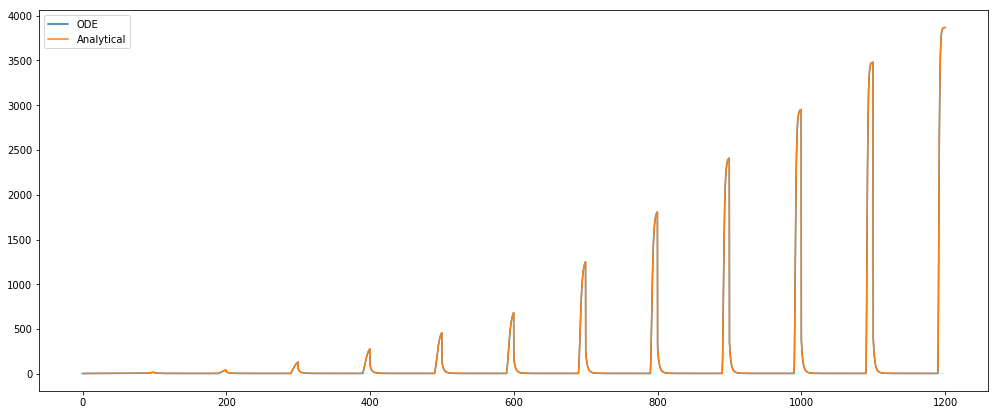

In [6]:
p = m2.suggested_parameters()
t = m2.suggested_times()

v1 = m1.simulate(p, t)
v2 = m2.simulate(p, t)

plt.figure(figsize=(17, 7))
plt.plot(t, v1, label='ODE')
plt.plot(t, v2, label='Analytical')
plt.legend()
plt.show()

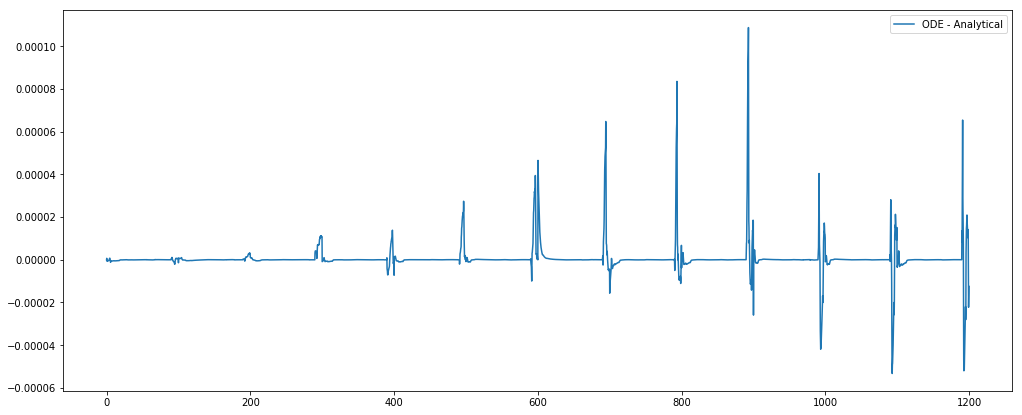

In [7]:
e = v1 - v2
plt.figure(figsize=(17, 7))
plt.plot(t, e, label='ODE - Analytical')
plt.legend()
plt.show()

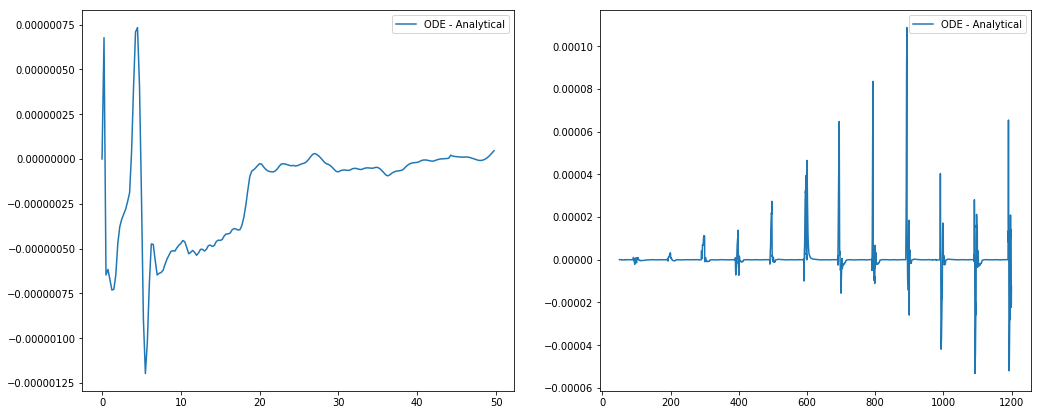

In [8]:
i = 200
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
plt.plot(t[:i], e[:i], label='ODE - Analytical')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(t[i:], e[i:], label='ODE - Analytical')
plt.legend()
plt.show()

In [9]:
print(m1._n0)
print(m2._n0)

0.3
0.3


In [10]:
print(v1[0])
print(v2[0])
print(t[0])

3.7907999999999995
3.7907999999999995
0.0
